In [378]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import seaborn as sns
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Input, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, accuracy_score, mean_squared_error, confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline

pd.options.mode.chained_assignment = None

# 1 - Load dataset
For now I'll work with 3 second samples. Later might try with 5sec samples

In [324]:
#features_3_sec = pd.read_csv('./Data/features_3_sec.csv')
dataset = pd.read_csv('./Data/final_dataset.csv')
dataset = dataset.drop(columns=['id', 'seen_by_model', 'createdAt', 'updatedAt', 'deletedAt'])
#features_30_sec = pd.read_csv('./Data/features_30_sec.csv')
dataset.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,0.441011,0.098403,0.308838,0.010569,3328.124539,8.107549e+05,3382.691560,114583.284474,7897.323031,1.917331e+06,...,42.023411,-5.012711,66.960938,-0.968601,87.470032,2.991356,59.765133,-1.670792,59.670425,7
1,0.370265,0.083063,0.171207,0.006743,2915.715009,1.556398e+06,2599.689672,324970.562618,5661.195497,5.154728e+06,...,94.394127,1.313031,144.447861,5.818873,138.011856,4.596396,144.546539,1.729125,211.818741,7
2,0.385647,0.071537,0.229402,0.015564,3880.270183,2.722230e+06,3186.927682,254165.389259,7703.815192,5.101757e+06,...,89.115379,5.156198,82.118690,2.303481,64.394051,0.785539,59.500866,-2.959064,73.443031,7
3,0.407606,0.107868,0.079086,0.000538,2271.813617,6.391978e+05,2707.634095,187545.070021,5239.177972,3.272871e+06,...,58.049915,-11.866402,100.287689,-3.473018,122.847267,-2.771165,68.308220,-0.633971,63.867836,7
4,0.397764,0.072330,0.242004,0.005612,2911.060481,5.488350e+05,2956.118960,145420.851816,6284.660711,2.669257e+06,...,50.164764,3.505230,64.743500,3.052081,117.361862,-1.915870,47.333481,2.078118,60.737377,7


In [325]:
dataset.describe()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
count,18174.000000,18174.000000,18174.000000,18174.000000,18174.000000,1.817400e+04,18174.000000,1.817400e+04,18174.000000,1.817400e+04,...,18174.000000,18174.000000,18174.000000,18174.000000,18174.000000,18174.000000,18174.000000,18174.000000,18174.000000,18174.000000
mean,0.379295,0.077021,0.135572,0.002687,2134.875117,4.510874e+05,2223.325359,1.417981e+05,4438.402746,1.835587e+06,...,54.598758,-3.468213,55.100700,1.714759,56.033552,-2.496534,59.438897,0.900708,63.174340,4.106086
std,0.142422,0.036724,0.084039,0.003816,802.236797,4.533324e+05,622.509385,1.312559e+05,1785.475510,1.606003e+06,...,34.072636,4.792359,34.595491,4.831382,35.939634,4.548077,38.850464,4.991360,44.661200,2.719498
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,...,0.000000,-29.104006,0.000000,-29.340727,0.000000,-30.064680,0.000000,-30.964809,0.000000,0.000000
25%,0.285098,0.053865,0.081105,0.000547,1527.237053,1.286404e+05,1856.116472,4.986841e+04,3064.469951,5.677438e+05,...,33.935047,-6.441645,33.550750,-1.074171,34.136117,-5.176787,35.446934,-2.055657,35.867638,2.000000
50%,0.378518,0.077365,0.119931,0.001442,2197.585269,3.133750e+05,2337.079347,1.107969e+05,4668.758157,1.475304e+06,...,48.061140,-3.548226,48.219650,1.847504,48.411140,-2.640953,51.189043,1.098168,53.174356,4.000000
75%,0.471700,0.100983,0.170582,0.003007,2701.097807,6.432060e+05,2668.133136,1.970407e+05,5721.218440,2.747373e+06,...,67.605717,-0.607902,68.607605,4.625885,68.796925,0.011364,73.783278,4.028334,78.724277,6.000000
max,1.000000,0.218875,0.511213,0.046327,5723.361241,8.328621e+06,3900.406003,1.928908e+06,9862.207031,1.708614e+07,...,558.112000,30.542461,576.210999,31.429256,628.466858,28.347557,765.618164,32.883530,997.057739,9.000000


In [326]:
dataset.columns

Index(['chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var',
       'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'tempo', 'mfcc1_mean', 'mfcc1_var',
       'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean', 'mfcc3_var', 'mfcc4_mean',
       'mfcc4_var', 'mfcc5_mean', 'mfcc5_var', 'mfcc6_mean', 'mfcc6_var',
       'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean', 'mfcc8_var', 'mfcc9_mean',
       'mfcc9_var', 'mfcc10_mean', 'mfcc10_var', 'mfcc11_mean', 'mfcc11_var',
       'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean', 'mfcc13_var', 'mfcc14_mean',
       'mfcc14_var', 'mfcc15_mean', 'mfcc15_var', 'mfcc16_mean', 'mfcc16_var',
       'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean', 'mfcc18_var', 'mfcc19_mean',
       'mfcc19_var', 'mfcc20_mean', 'mfcc20_var', 'label'],
      dtype='object')

# 2 - Analyse dataset


In [327]:
dataset = dataset.sample(frac=1)
training_set, testing_set, _, __ = train_test_split(dataset, dataset, test_size=0.1)

In [328]:
len(training_set), len(testing_set)

(16356, 1818)

In [330]:
len(training_set.columns)

56

## 2.1 - Label feature correlations
The following heatmap shows the correlation between every feature and the prediction label. With this data, we can check how much each feature affects the outcome of the label and find out which ones can be dropped (values closer to 0), which by analysing the heatmap, we can observe that this is the case for some features.

<AxesSubplot:>

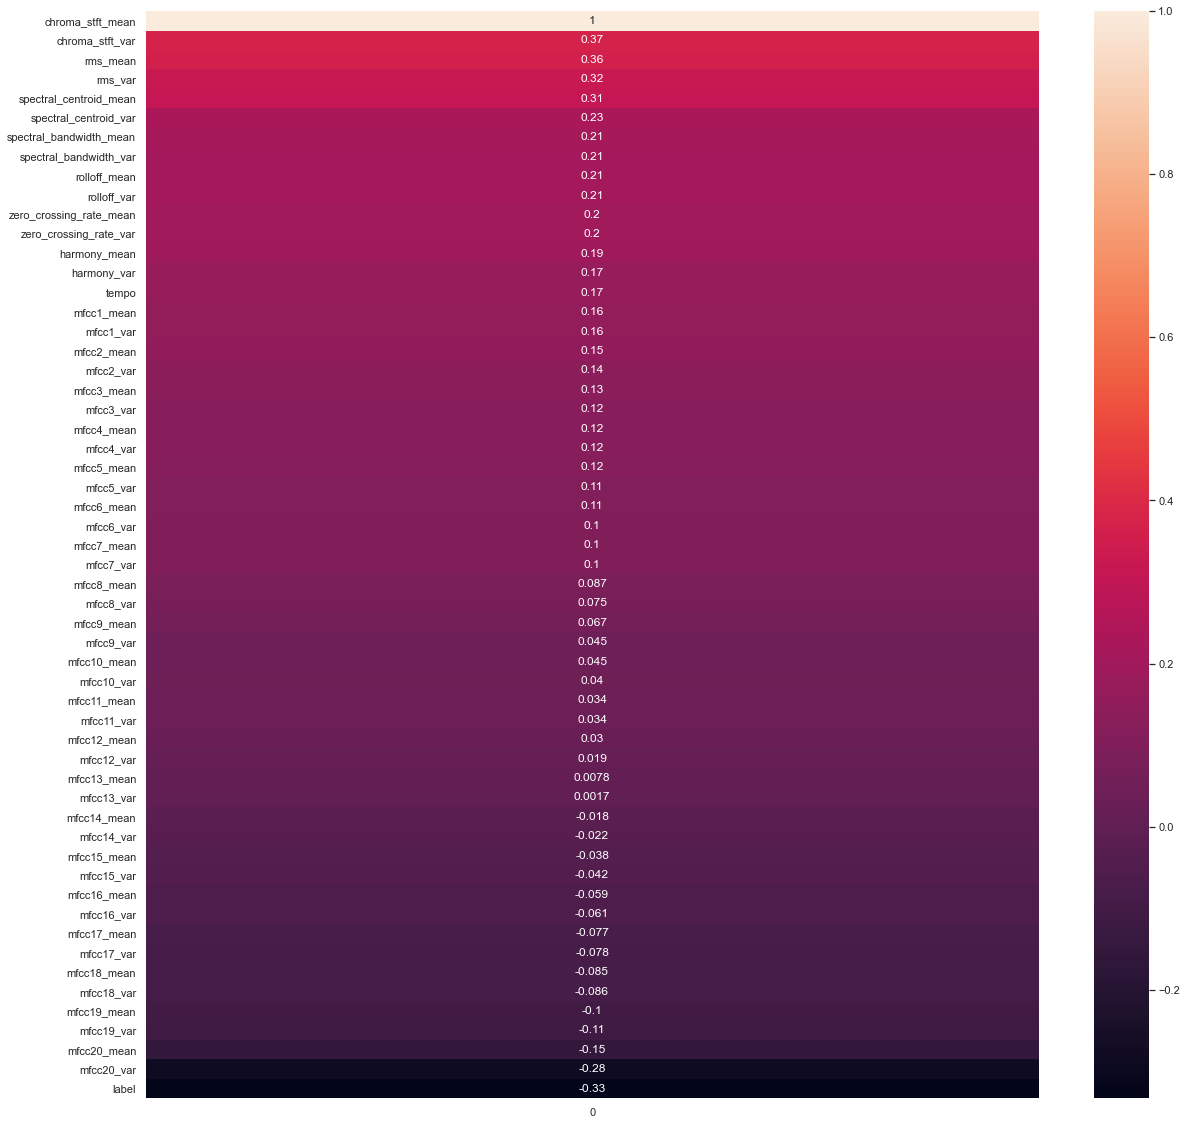

In [331]:
training_corr = training_set.corr()
corr = pd.DataFrame(data=training_corr.label)
corr = corr.sort_values(by=['label'], ascending=False)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corr.label.values.reshape(56,1),  annot=True, ax=ax, yticklabels=training_set.columns)

## 2.2 - Feature boxplotting
With the boxplots we can find out whether the dataset has outliers or not. By analysing the plots below, we can see that the majority of the mean based features don't have as much outliers as the variance based ones.

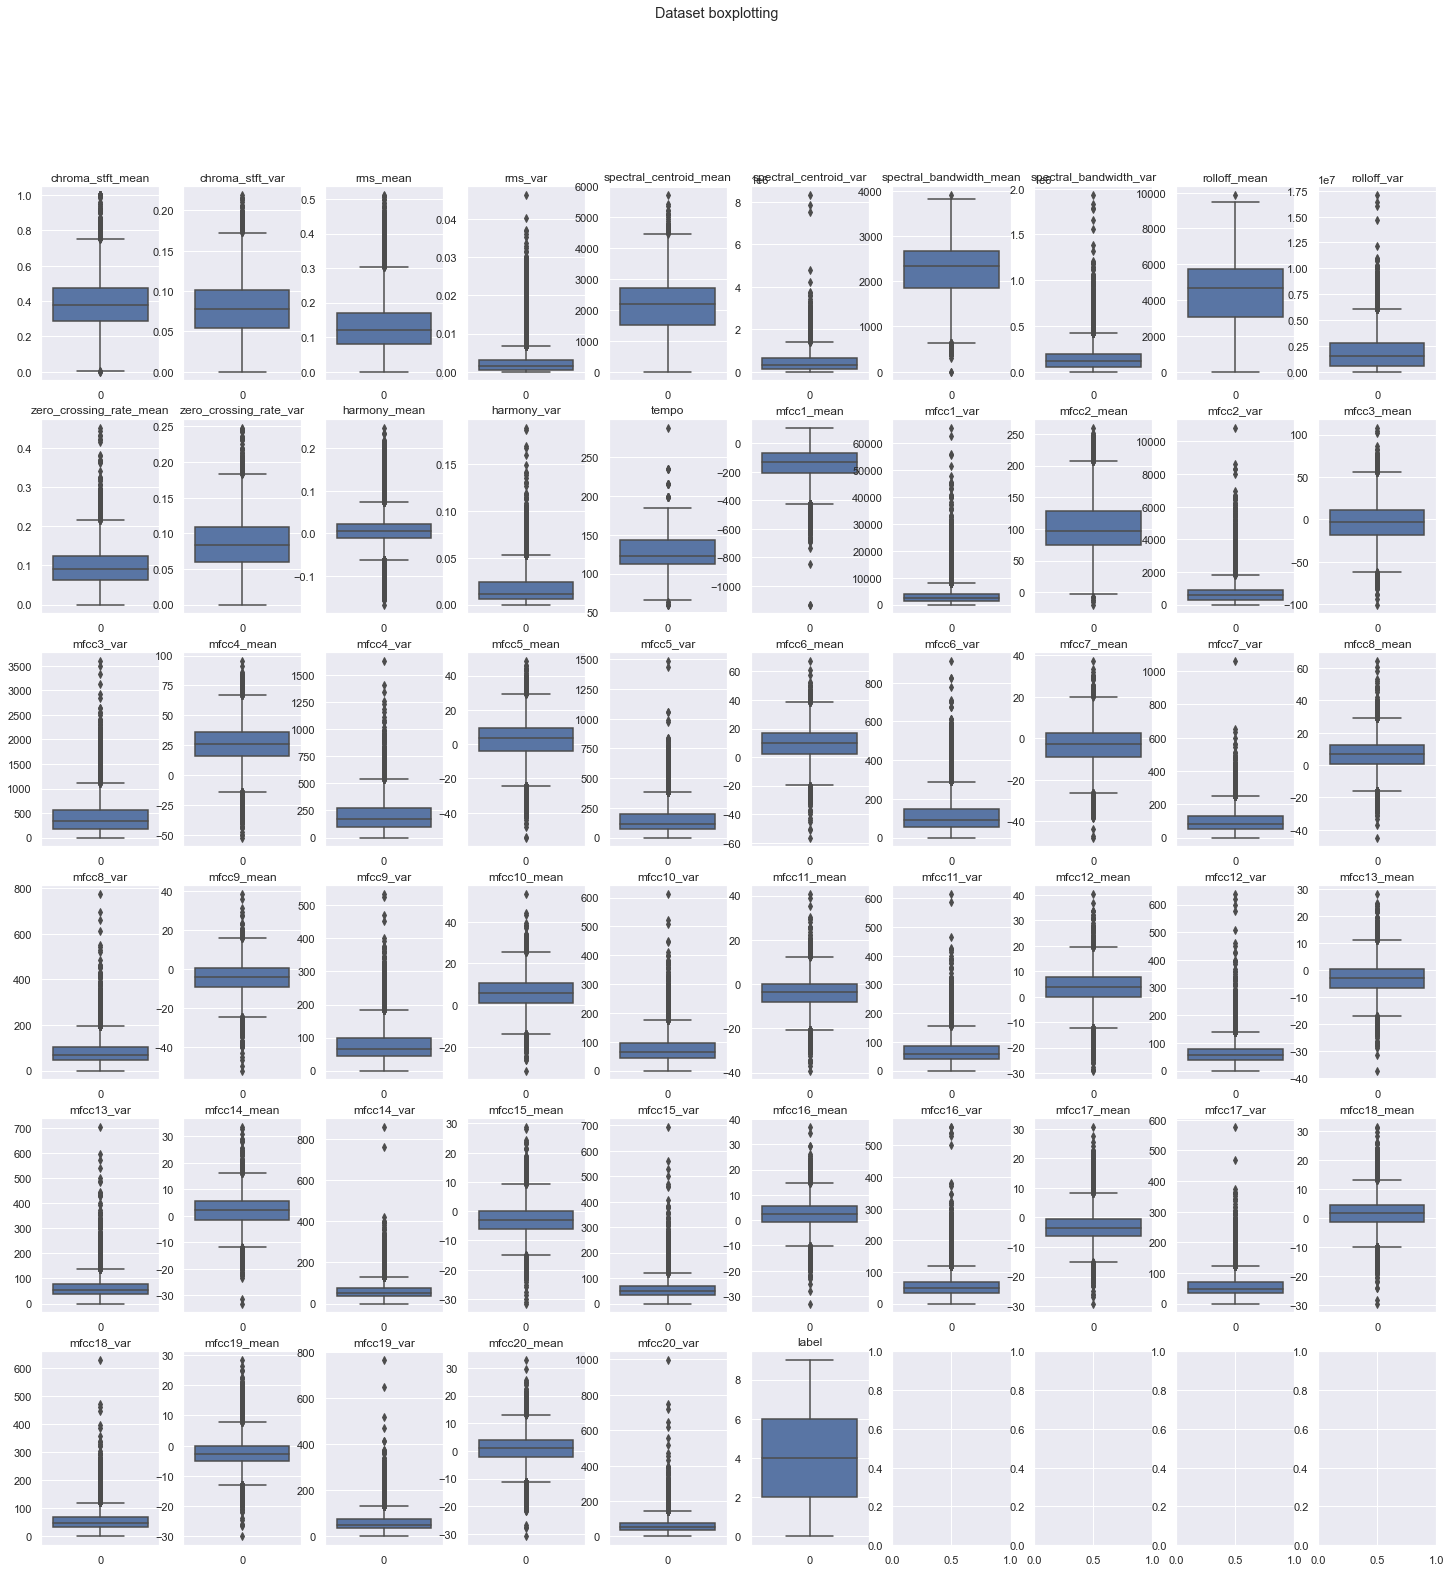

In [332]:
fig, axes = plt.subplots(6, 10, figsize=(25, 25))
fig.suptitle('Dataset boxplotting')

for r in range(6):
    for c in range(10):
        if r == 5 and c > 5: break
        col = training_set.columns[r*10+c]
        sns.boxplot(ax=axes[r, c], data=training_set[col])
        axes[r, c].set_title(col)

## 2.3 - Data distributions

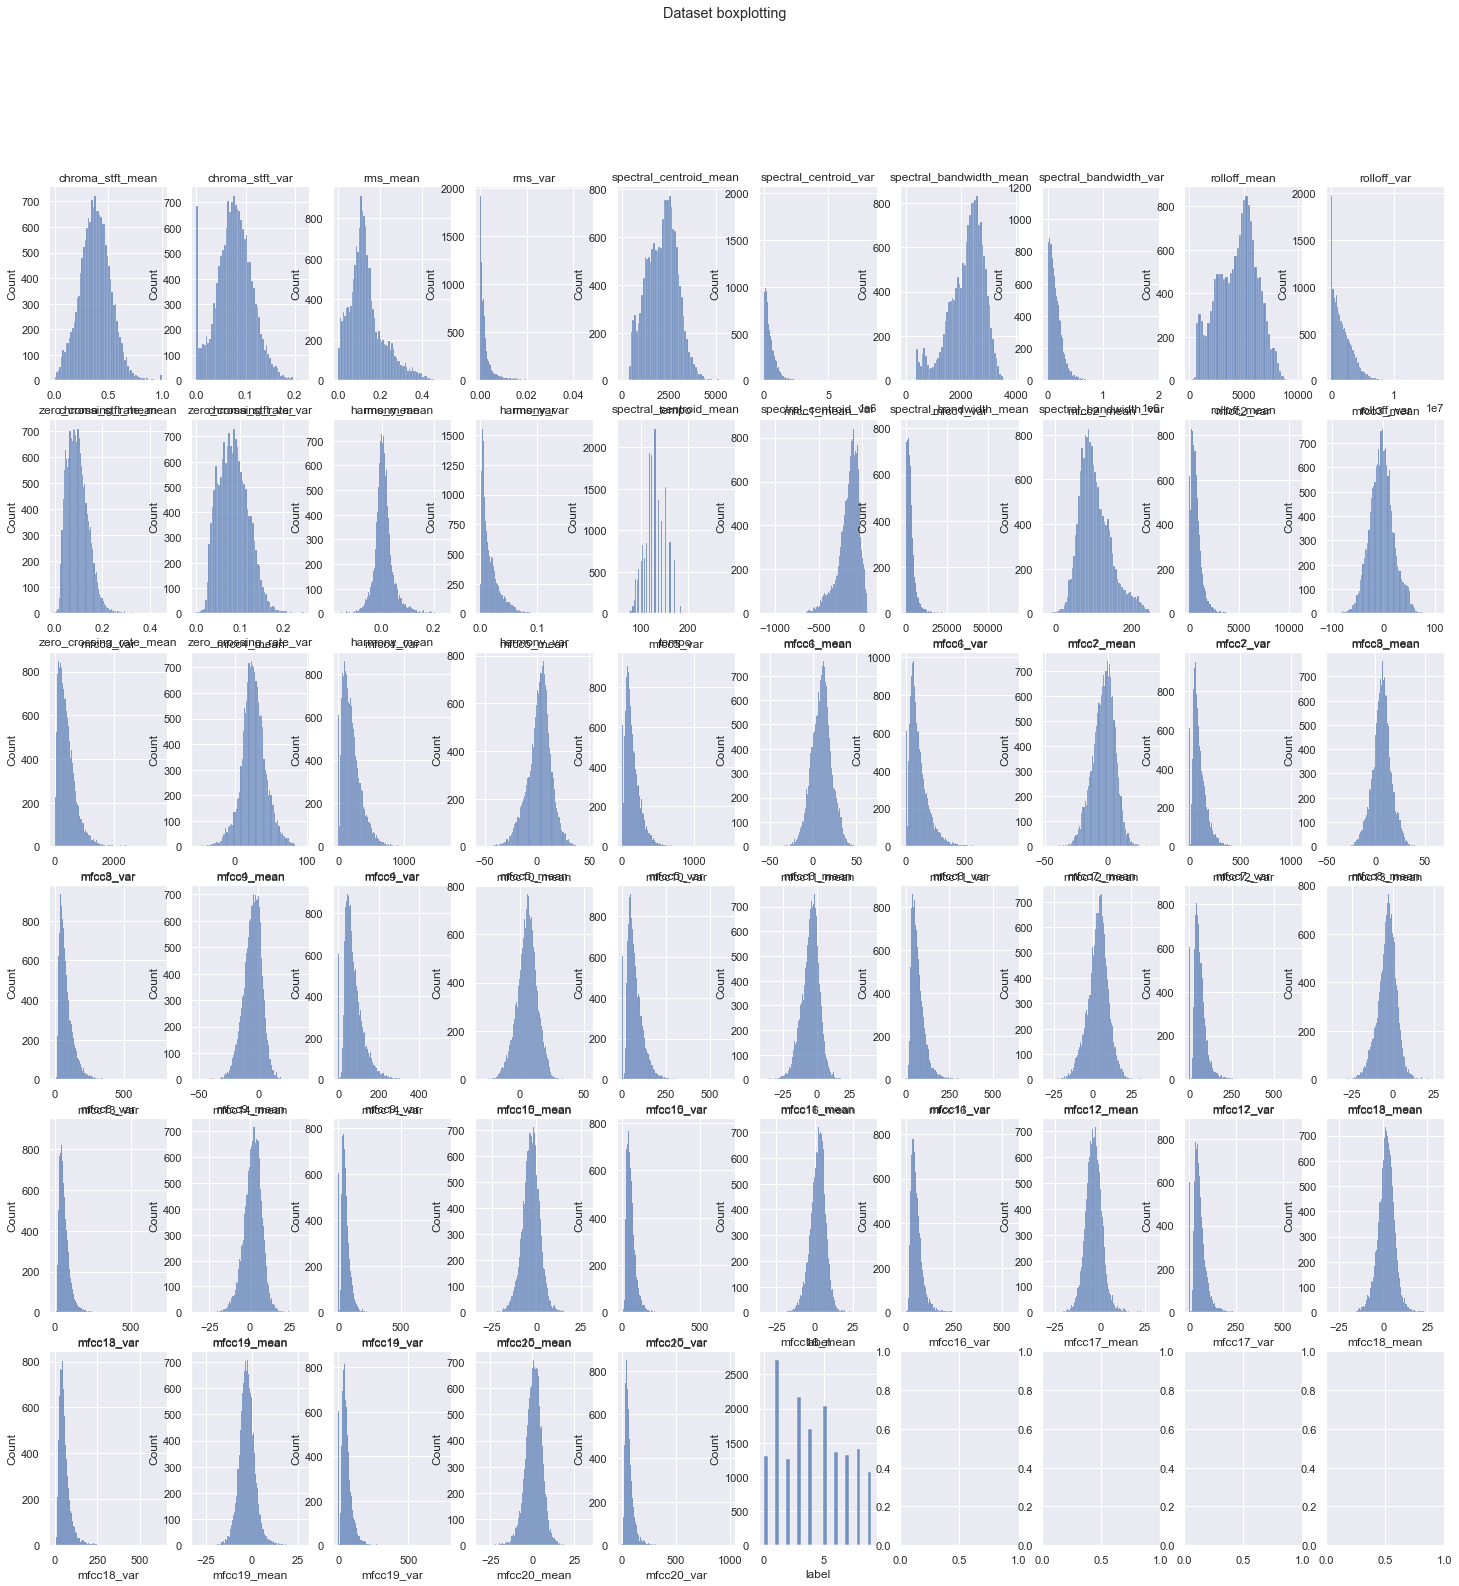

In [333]:
fig, axes = plt.subplots(6, 10, figsize=(25, 25))
fig.suptitle('Dataset boxplotting')

for r in range(6):
    for c in range(10):
        if r == 5 and c > 5: break
        col = training_set.columns[r*10+c]
        #sns.boxplot(ax=axes[r, c], data=training_set[col])
        sns.histplot(ax=axes[r, c], data=training_set[col])
        axes[r, c].set_title(col)

## 2.4 - Check and handle duplicates

In [341]:
duplicates = training_set[training_set.duplicated(training_set.columns[:len(training_set.columns)-1], keep=False) & ~training_set.duplicated(training_set.columns, keep=False)]
training_set = training_set.drop(duplicates.index)
len(training_set[training_set.duplicated(training_set.columns[:len(training_set.columns)-1], keep=False) & ~training_set.duplicated(training_set.columns, keep=False)])

0

## 2.5 - Data balance

In [342]:
label_counts = {}
for i in range(10):
    label_counts[str(i)] = len(training_set[training_set.label == i])
label_counts

{'0': 1307,
 '1': 2704,
 '2': 1261,
 '3': 2168,
 '4': 1705,
 '5': 2037,
 '6': 1358,
 '7': 1327,
 '8': 1406,
 '9': 1075}

# 3 - Data pre-processing

## 3.1 - Handle outliers

In [343]:
list(training_set.columns).index(feature)

54

In [344]:
#outliers = {}
threshold = 3 # 3 standard deviations

for feature in training_set.drop(columns='label').columns:
    median = training_set[feature].median()
    std = training_set[feature].std()

    outliers = training_set[(abs(training_set[feature] - median) / std) > threshold].index
    
    training_set.loc[training_set.index.isin(outliers), feature] = training_set[feature].mean()

training_set.describe()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
count,16348.000000,16348.000000,16348.000000,16348.000000,16348.000000,1.634800e+04,16348.000000,16348.000000,16348.000000,1.634800e+04,...,16348.000000,16348.000000,16348.000000,16348.000000,16348.000000,16348.000000,16348.000000,16348.000000,16348.000000,16348.000000
mean,0.376796,0.076804,0.130608,0.002173,2126.152934,4.148286e+05,2238.986097,131513.122780,4428.497820,1.755441e+06,...,52.171610,-3.549498,52.327555,1.667575,53.039367,-2.612954,56.525874,0.944673,59.642261,4.104172
std,0.138219,0.036402,0.075837,0.002395,795.598731,3.639414e+05,596.338156,102313.781565,1787.315648,1.435444e+06,...,26.848361,4.383089,27.303200,4.452215,28.174005,4.086647,30.709608,4.626270,34.303201,2.721393
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,464.573141,0.000000,0.000000,0.000000e+00,...,0.000000,-17.919788,0.000000,-12.675083,0.000000,-16.249062,0.000000,-13.858658,0.000000,0.000000
25%,0.284790,0.053901,0.080854,0.000549,1519.471104,1.289224e+05,1877.797331,49981.678454,3054.217451,5.671236e+05,...,33.998322,-6.377095,33.537067,-1.046689,34.165493,-5.140353,35.415640,-1.966577,35.871260,2.000000
50%,0.378101,0.077193,0.119427,0.001436,2184.729879,3.134782e+05,2335.042731,111239.867854,4653.907241,1.473851e+06,...,48.086723,-3.503021,48.295794,1.765067,48.433447,-2.605969,51.326107,1.040054,53.226053,4.000000
75%,0.469730,0.100926,0.164268,0.002686,2696.005471,6.065740e+05,2665.895782,189563.632922,5715.331960,2.653515e+06,...,66.058390,-0.700139,66.568443,4.542646,66.563721,-0.117751,71.634155,3.970203,76.430490,6.000000
max,0.805666,0.187851,0.370982,0.012854,4593.247428,1.677866e+06,3900.406003,506045.739602,9862.207031,6.314096e+06,...,150.780701,10.865704,152.642761,16.370598,156.667557,11.013688,167.268051,15.919265,186.882126,9.000000


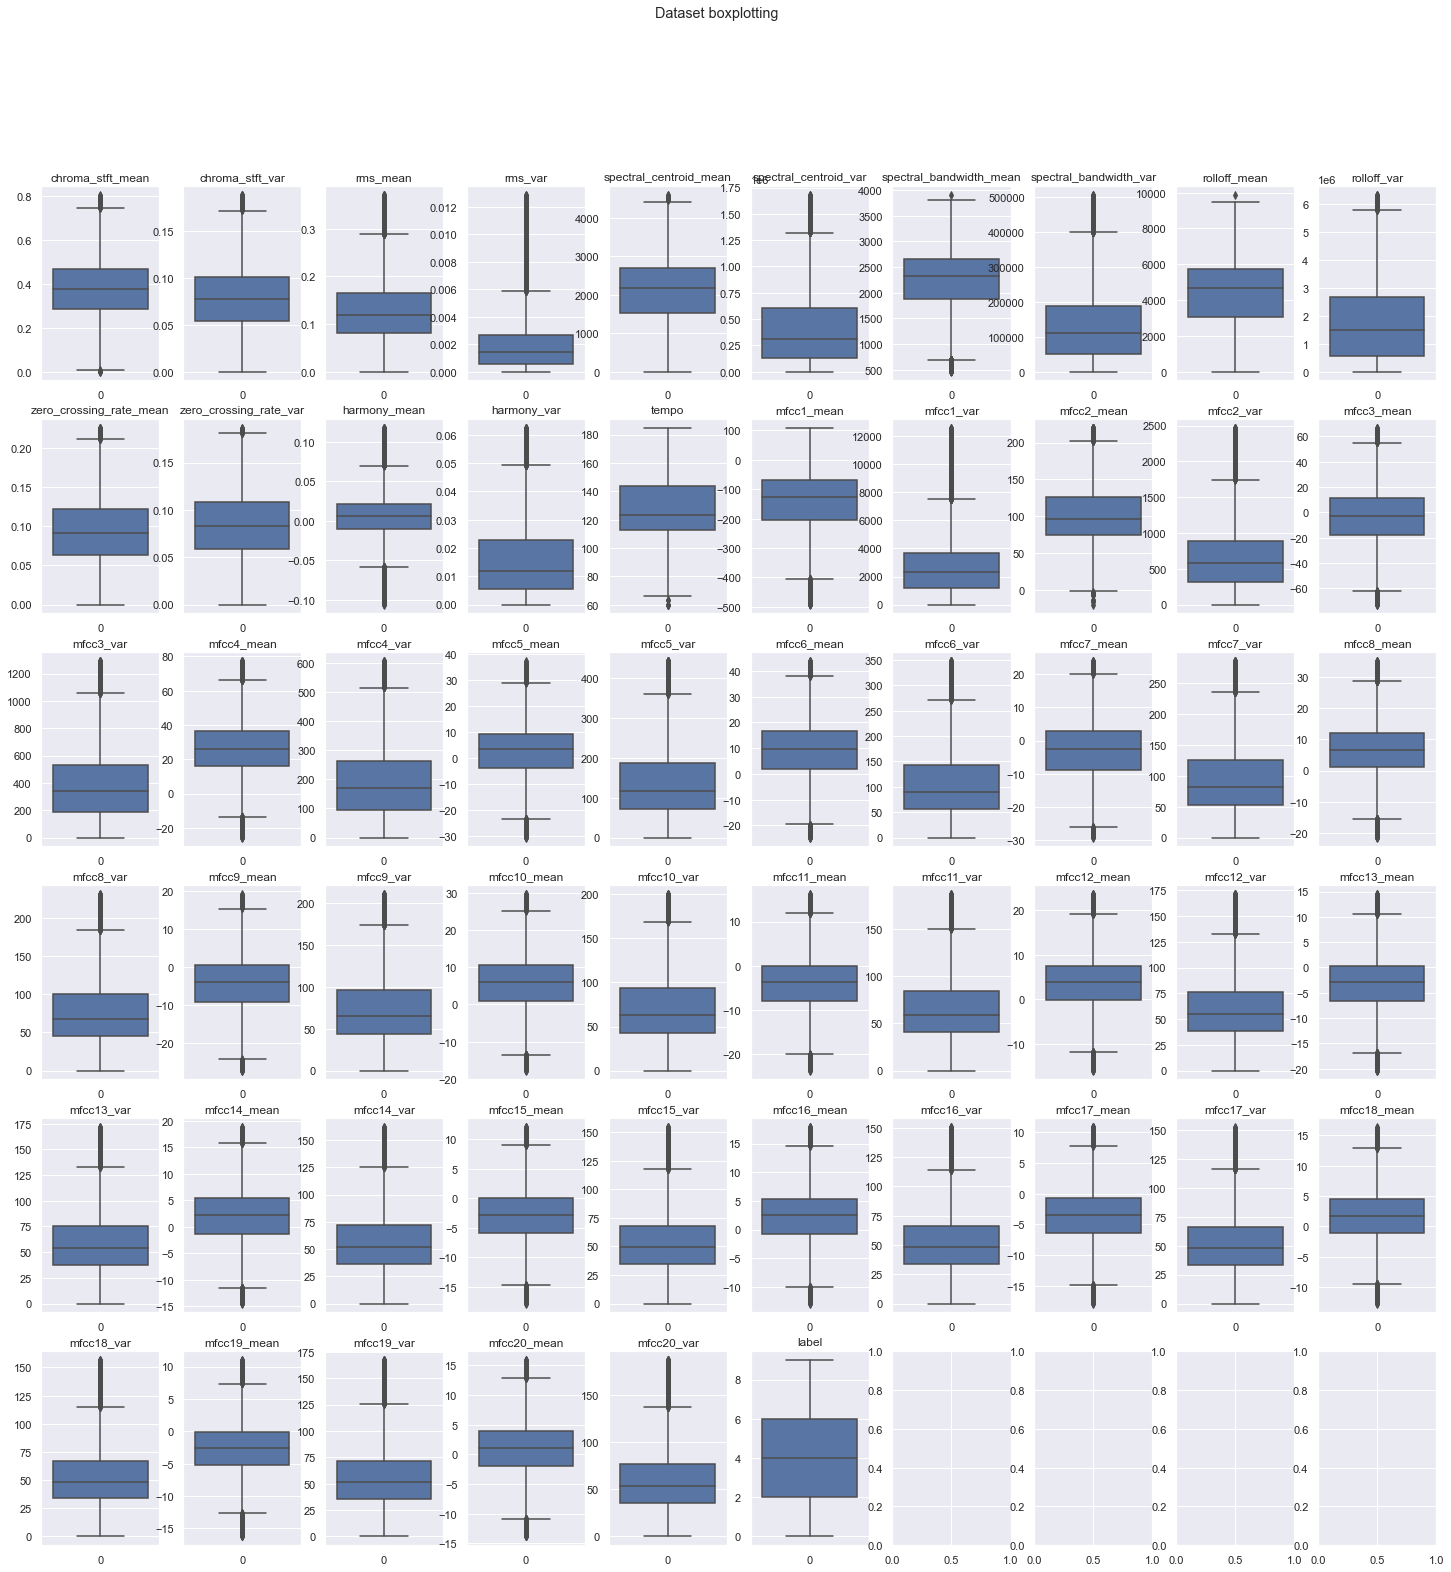

In [345]:
fig, axes = plt.subplots(6, 10, figsize=(25, 25))
fig.suptitle('Dataset boxplotting')

for r in range(6):
    for c in range(10):
        if r == 5 and c > 5: break
        col = training_set.columns[r*10+c]
        sns.boxplot(ax=axes[r, c], data=training_set[col])
        axes[r, c].set_title(col)

As we can see, most of the outliers were handled properly by changing their value to it's feature's median.

## 3.2 - Scale and normalize data

In [348]:
X_tmp = training_set.drop(columns='label')
y_tmp = pd.DataFrame(data=training_set.label.values, columns=['label'])

scaler = StandardScaler()
scaler.fit(X_tmp)
scaled_training_set = pd.DataFrame(scaler.transform(X_tmp), columns=X_tmp.columns)
scaled_training_set = pd.concat([scaled_training_set, y_tmp], axis=1, join='inner')
scaled_training_set.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,-0.135785,0.975513,-0.859712,-0.485069,-1.216515,-0.985843,-1.225927,-0.902809,-1.252982,-1.048326,...,0.456235,-0.174063,1.564108,-1.023542,0.515241,-0.580250,0.226360,0.943575,-0.502531,1
1,0.438547,0.300629,0.494094,-0.567034,1.317515,-0.662924,1.018637,-0.866825,1.291220,-0.875721,...,-0.820236,0.504650,-0.371671,-0.018151,-0.405265,-0.424732,-0.551315,0.606120,-0.566990,7
2,-0.179118,0.043150,-0.490065,-0.573458,-1.114247,-1.133293,-1.586388,-1.228904,-1.315542,-1.213025,...,-0.675246,-0.362098,-1.784391,-2.374864,-1.284359,-1.837437,-1.580896,0.355254,0.697273,1
3,0.751049,0.810670,-0.045223,-0.848158,-0.329459,0.250227,0.139971,1.238948,-0.149541,0.775810,...,0.415341,1.074401,-0.632779,-0.409472,-0.717417,0.100957,-0.495494,1.008461,0.532516,7
4,-2.289244,-1.930511,-0.876766,0.081329,-2.047740,-1.132806,-0.031476,-1.256152,-2.027279,-1.218659,...,0.656161,1.578294,-0.506965,0.207439,0.573402,2.014117,1.212608,1.008462,0.667343,1


In [373]:
X_tmp = testing_set.drop(columns='label')
y_tmp = pd.DataFrame(data=testing_set.label.values, columns=['label'])

scaled_testing_set = pd.DataFrame(scaler.transform(X_tmp), columns=X_tmp.columns)
scaled_testing_set = pd.concat([scaled_testing_set, y_tmp], axis=1, join='inner')
scaled_testing_set.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,1.239332,0.403421,-0.490770,-0.485526,0.831174,0.366005,1.100848,0.416610,0.945074,0.480727,...,0.318845,0.291946,-0.117062,-1.887900,-0.899070,-0.575158,-1.037414,-0.596852,-0.736308,2
1,-0.531391,0.318118,1.013982,0.831488,0.460958,0.100500,0.452146,0.059046,0.430224,0.217141,...,0.646269,-1.153307,0.103477,0.188860,-0.204079,-0.217288,0.219245,-0.077771,-0.326798,8
2,-1.355844,-0.991430,0.264912,0.631149,-0.471148,-0.158433,-0.341527,0.240083,-0.330845,0.009069,...,-0.086495,-1.268386,-0.745902,-0.694595,-0.129279,0.088934,-0.223647,-1.019049,-0.512005,0
3,1.051181,0.180494,1.141719,-0.672315,0.949907,-0.987849,0.197683,-1.106003,0.672688,-1.087917,...,-1.063295,-1.397425,-1.195951,0.445826,-0.972335,-1.110213,-0.659218,0.721063,-0.797837,6
4,0.932930,0.319354,2.106209,6.547155,0.625328,1.271568,0.467620,0.328534,0.538700,0.800437,...,0.089028,0.779016,0.703628,0.814514,0.549724,1.695041,1.087570,1.675873,1.046065,3


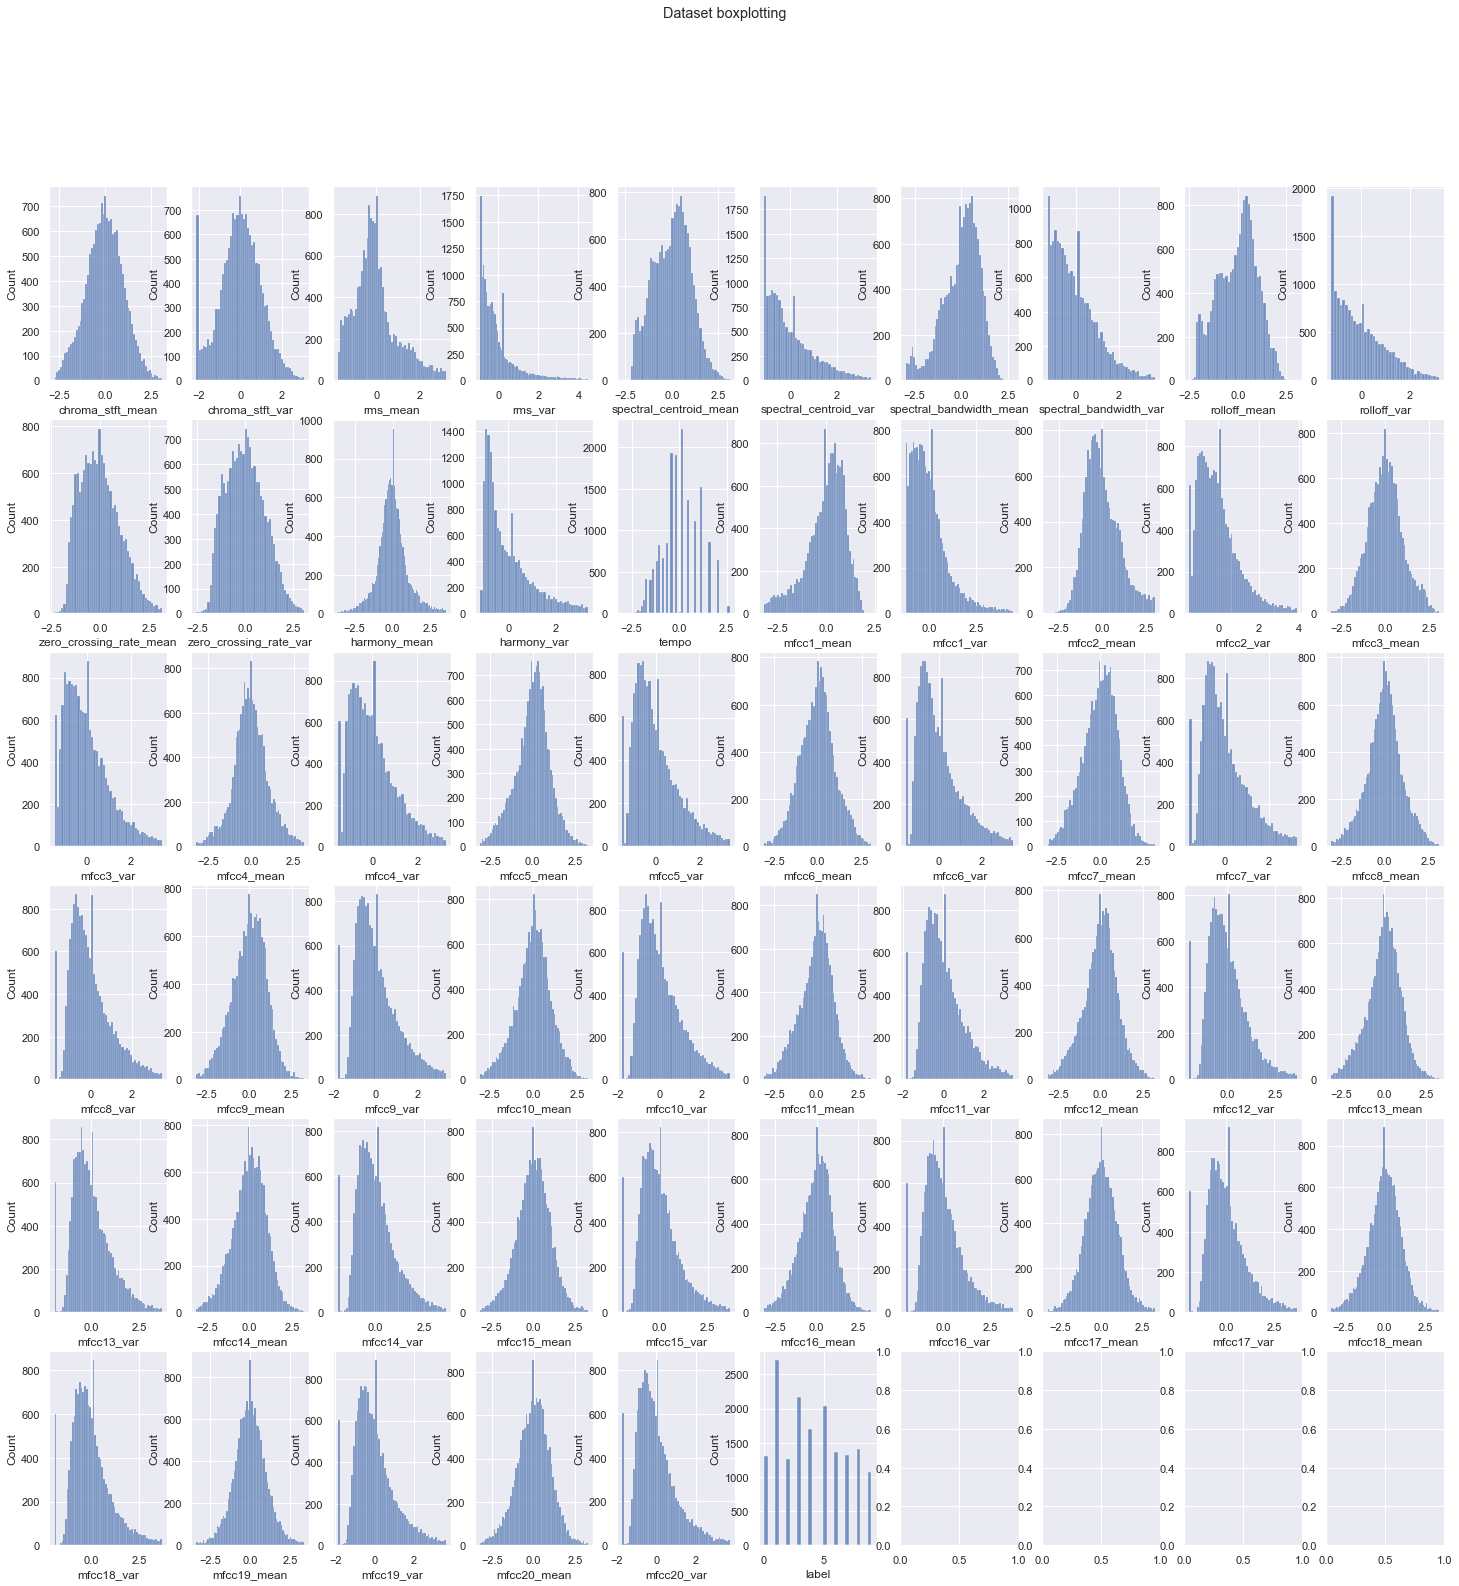

In [349]:
fig, axes = plt.subplots(6, 10, figsize=(25, 25))
fig.suptitle('Dataset boxplotting')

for r in range(6):
    for c in range(10):
        if r == 5 and c > 5: break
        col = scaled_training_set.columns[r*10+c]
        sns.histplot(ax=axes[r, c], data=scaled_training_set[col])

## 3.3 - Feature selection

In this section we'll analyse the correlation heatmap seen previously and select the features that perform better overall. This selection will be done by selecting the features based on a threshold and evaluate some models by using cross-validation with the KNN and Decision Tree algorithms.

<AxesSubplot:>

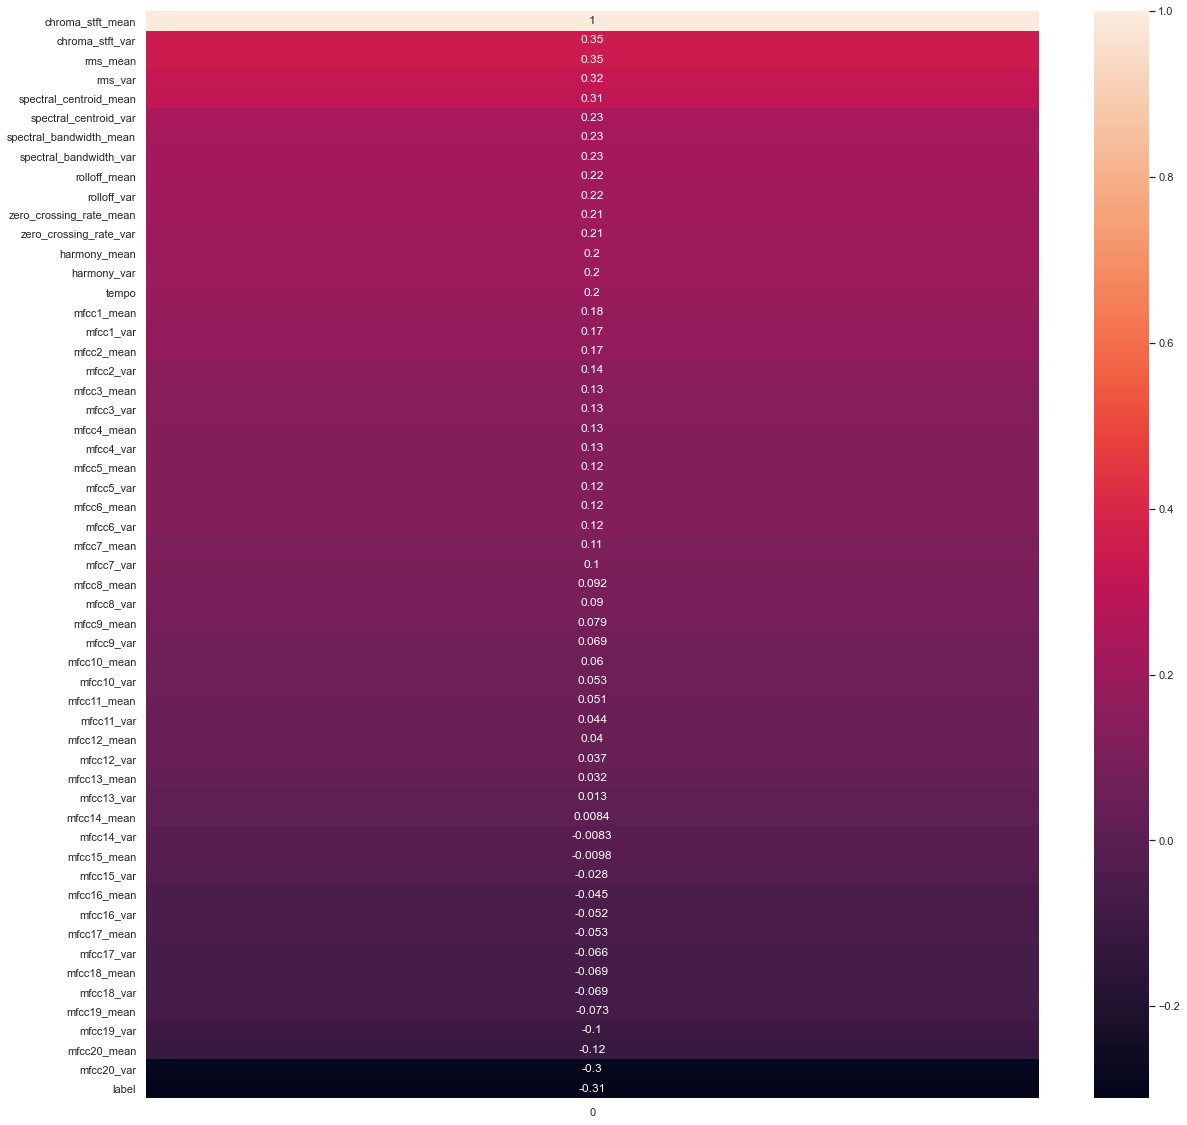

In [350]:
scaled_training_corr = scaled_training_set.corr()
corr = pd.DataFrame(data=scaled_training_corr.label)
corr = corr.sort_values(by=['label'], ascending=False)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corr.label.values.reshape(56,1),  annot=True, ax=ax, yticklabels=scaled_training_set.columns)

In [354]:
max_thresholds = [0, 0.05, 0.1, 0.15, 0.2, 0.25]
min_thresholds = [0, -0.05, -0.1, -0.15, -0.2, -0.25]
knn_model = KNeighborsClassifier(n_neighbors=2)
svm_model = SVC()
dt_model = DecisionTreeClassifier()
results = []

for max_thresh in max_thresholds:
    for min_thresh in min_thresholds:
        print('.', end='')
        corr = scaled_training_set.corr().label
        selected_set = corr[(corr < min_thresh) | (corr >= max_thresh)]
        not_selected_cols = list(corr[(corr > min_thresh) & (corr < max_thresh)].index)
        selected_set = pd.DataFrame(data=scaled_training_set, columns=scaled_training_set.columns).drop(columns=not_selected_cols)
        selected_X = selected_set.drop(columns='label')
        selected_y = selected_set.label

        results.append({
            'min_thresh': min_thresh,
            'max_thresh': max_thresh,
            'knn': sum(cross_val_score(knn_model, selected_X, selected_y, cv=4)) / 4,
            'decision-tree': sum(cross_val_score(dt_model, selected_X, selected_y, cv=4)) / 4,
            'svm': sum(cross_val_score(svm_model, selected_X, selected_y, cv=4)) / 4,
        })
        
results_df = pd.DataFrame(results)

....................................

In [355]:
results_df = results_df.sort_values(['knn', 'decision-tree', 'svm'], ascending=False).reset_index()
results_df

,index,min_thresh,max_thresh,knn,decision-tree,svm
0,1,-0.05,0.00,0.838696,0.639467,0.818510
1,2,-0.10,0.00,0.838635,0.640874,0.816858
2,3,-0.15,0.00,0.835821,0.639344,0.811170
3,5,-0.25,0.00,0.835821,0.638304,0.811170
4,4,-0.20,0.00,0.835821,0.637203,0.811170
5,0,0.00,0.00,0.833558,0.638549,0.815451
6,8,-0.10,0.05,0.827196,0.623868,0.794409
7,7,-0.05,0.05,0.823526,0.617751,0.797773
8,9,-0.15,0.05,0.822302,0.624602,0.790066
9,11,-0.25,0.05,0.822302,0.622094,0.790066


Given the previous results, we can conclude that the best relationship between model performance and number of features is obtained when removing the features with a correlation value between -0.25 and 0.0.<br/>
Now let's move on and experiment with the PCA and Isomap embedding algorithms.

In [374]:
min_thresh = -0.25
max_thresh = 0
corr = scaled_training_set.corr().label
selected_set = corr[(corr < min_thresh) | (corr >= max_thresh)]
not_selected_cols = list(corr[(corr > min_thresh) & (corr < max_thresh)].index)
selected_set = pd.DataFrame(data=scaled_training_set, columns=scaled_training_set.columns).drop(columns=not_selected_cols)
selected_testing_set = pd.DataFrame(data=scaled_testing_set, columns=scaled_testing_set.columns).drop(columns=not_selected_cols)
print(len(selected_set.columns))
selected_set.head()

44


,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc11_mean,mfcc12_mean,mfcc13_mean,mfcc14_mean,mfcc15_mean,mfcc16_mean,mfcc18_mean,mfcc19_mean,mfcc20_mean,label
0,-0.135785,0.975513,-0.859712,-0.485069,-1.216515,-0.985843,-1.225927,-0.902809,-1.252982,-1.048326,...,-0.352017,-1.008334,-0.682928,0.609386,0.577260,-0.110169,-1.023542,-0.580250,0.943575,1
1,0.438547,0.300629,0.494094,-0.567034,1.317515,-0.662924,1.018637,-0.866825,1.291220,-0.875721,...,0.127694,-0.188168,-0.351137,1.238282,1.425489,0.711723,-0.018151,-0.424732,0.606120,7
2,-0.179118,0.043150,-0.490065,-0.573458,-1.114247,-1.133293,-1.586388,-1.228904,-1.315542,-1.213025,...,1.508381,-0.106417,0.181226,-0.045998,-0.269071,-0.076762,-2.374864,-1.837437,0.355254,1
3,0.751049,0.810670,-0.045223,-0.848158,-0.329459,0.250227,0.139971,1.238948,-0.149541,0.775810,...,-0.229611,1.041051,0.786273,0.603877,0.840369,0.087151,-0.409472,0.100957,1.008461,7
4,-2.289244,-1.930511,-0.876766,0.081329,-2.047740,-1.132806,-0.031476,-1.256152,-2.027279,-1.218659,...,-1.207653,-2.551892,-1.728501,-1.733236,1.335635,0.996422,0.207439,2.014117,1.008462,1


## 3.4 - PCA

In [363]:
n_components = [10, 20, 30, 40]
res = []
selected_X = selected_set.drop(columns='label')
selected_y = selected_set.label

res.append({
    'n_components': -1,
    'knn': sum(cross_val_score(KNeighborsClassifier(), selected_X, selected_y, cv=4)) / 4,
    'decision-tree': sum(cross_val_score(DecisionTreeClassifier(), selected_X, selected_y, cv=4)) / 4,
    'svm': sum(cross_val_score(SVC(), selected_X, selected_y, cv=4)) / 4,
})

for nc in n_components:
    knn_pipeline = make_pipeline(PCA(n_components=nc), KNeighborsClassifier())
    dt_pipeline = make_pipeline(PCA(n_components=nc), DecisionTreeClassifier())
    svm_pipeline = make_pipeline(PCA(n_components=nc), SVC())
    
    res.append({
        'n_components': nc,
        'knn': sum(cross_val_score(knn_pipeline, selected_X, selected_y, cv=4)) / 4,
        'decision-tree': sum(cross_val_score(dt_pipeline, selected_X, selected_y, cv=4)) / 4,
        'svm': sum(cross_val_score(svm_pipeline, selected_X, selected_y, cv=4)) / 4,
    })
    
res_df = pd.DataFrame(res)
res_df

,n_components,knn,decision-tree,svm
0,-1,0.823098,0.640445,0.811170
1,10,0.729019,0.578542,0.679410
2,20,0.805664,0.585270,0.770431
3,30,0.818510,0.579887,0.797529
4,40,0.823465,0.575300,0.810741


As shown in the table above, using PCA to reduce the number of features doesn't give better results. When used 40 components the results were very similar to when not using PCA (having 44 features), with the exception of the Decision Tree model, where the performance was best when not using the PCA algorithm.

## 3.5 - Isomap embedding

In [369]:
n_neighbors = [5, 7]
n_components = [10, 20, 30]
res = []
selected_X = selected_set.drop(columns='label')
selected_y = selected_set.label

res.append({
    'n_components': -1,
    'n_neighbors': -1,
    'knn': sum(cross_val_score(KNeighborsClassifier(), selected_X, selected_y, cv=4)) / 4,
    'svm': sum(cross_val_score(SVC(), selected_X, selected_y, cv=4)) / 4,
})

for nc in n_components:
    for nn in n_neighbors:
        print("(" + str(nn) + ", " + str(nc) + ") ", end="")
        embedding = Isomap(n_components=nc, n_neighbors=nn)
        X_transformed = embedding.fit_transform(selected_X)
        
        res.append({
            'n_components': nc,
            'n_neighbors': nn,
            'knn': sum(cross_val_score(KNeighborsClassifier(), X_transformed, selected_y, cv=4)) / 4,
            'svm': sum(cross_val_score(SVC(), X_transformed, selected_y, cv=4)) / 4,
        })
    
res_df = pd.DataFrame(res)
res_df

(5, 10) (7, 10) (5, 20) (7, 20) (5, 30) (7, 30) 

,n_components,n_neighbors,knn,svm
0,-1,-1,0.823098,0.811170
1,10,5,0.752691,0.676474
2,10,7,0.733117,0.675924
3,20,5,0.777893,0.724737
4,20,7,0.767739,0.727306
5,30,5,0.778994,0.748838
6,30,7,0.775324,0.744189


After trying different parameters for the Isomap embedding, the results appeared to be worse than not using the Isomap. Because of this, we'll move on using the following features:

In [370]:
selected_set.columns

Index(['chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var',
       'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_var', 'tempo', 'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean',
       'mfcc2_var', 'mfcc3_mean', 'mfcc3_var', 'mfcc4_mean', 'mfcc4_var',
       'mfcc5_mean', 'mfcc5_var', 'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean',
       'mfcc7_var', 'mfcc8_mean', 'mfcc8_var', 'mfcc9_mean', 'mfcc9_var',
       'mfcc10_mean', 'mfcc10_var', 'mfcc11_mean', 'mfcc12_mean',
       'mfcc13_mean', 'mfcc14_mean', 'mfcc15_mean', 'mfcc16_mean',
       'mfcc18_mean', 'mfcc19_mean', 'mfcc20_mean', 'label'],
      dtype='object')

# 3 - Initial baseline models evaluation

In [375]:
X_train = selected_set.drop(columns='label')
y_train = selected_set.label
X_test = selected_testing_set.drop(columns='label')
y_test = selected_testing_set.label

## 3.1 - KNN

Accuracy: 0.8342927517097989


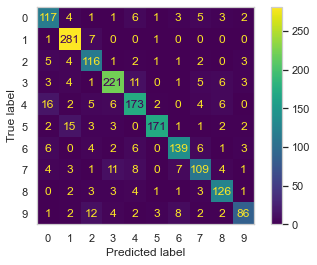

In [407]:
knn_model = KNeighborsClassifier()
knn_acc = sum(cross_val_score(knn_model, X_train, y_train, cv=6)) / 6
print("Accuracy: " + str(knn_acc))
knn_model.fit(X_train, y_train)
cm = confusion_matrix(y_test, knn_model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_model.classes_)
disp.plot()

## 3.2 - SVM 

Accuracy: 0.8191214350186585


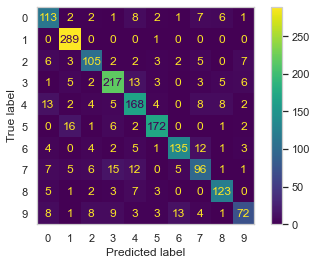

In [381]:
svm_model = SVC()
svm_acc = sum(cross_val_score(svm_model, X_train, y_train, cv=6)) / 6
print("Accuracy: " + str(svm_acc))
svm_model.fit(X_train, y_train)
cm = confusion_matrix(y_test, svm_model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_model.classes_)
disp.plot()

## 3.3 - Naive Bayes

Accuracy: 0.5474684422530278


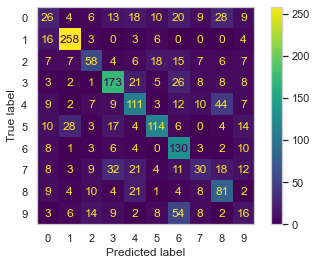

In [382]:
nb_model = GaussianNB()
nb_acc = sum(cross_val_score(nb_model, X_train, y_train, cv=6)) / 6
print("Accuracy: " + str(nb_acc))
nb_model.fit(X_train, y_train)
cm = confusion_matrix(y_test, nb_model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## 3.4 - Decision Tree

Accuracy: 0.6504171774733146


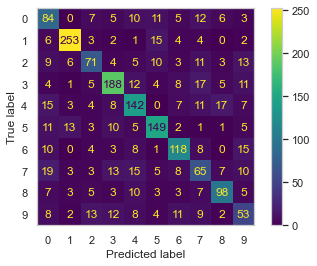

In [383]:
dt_model = DecisionTreeClassifier()
dt_acc = sum(cross_val_score(dt_model, X_train, y_train, cv=6)) / 6
print("Accuracy: " + str(dt_acc))
dt_model.fit(X_train, y_train)
cm = confusion_matrix(y_test, dt_model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## 3.5 - Random Forest

Accuracy: 0.8262183917336889


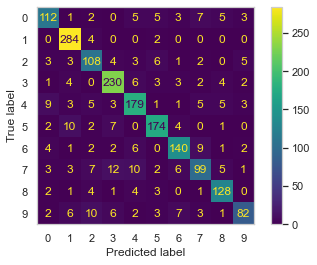

In [384]:
rf_model = RandomForestClassifier(n_estimators=300)
rf_acc = sum(cross_val_score(rf_model, X_train, y_train, cv=6)) / 6
print("Accuracy: " + str(rf_acc))
rf_model.fit(X_train, y_train)
cm = confusion_matrix(y_test, rf_model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## 3.6 - Neural Network

In [393]:
_X_train, X_val, _y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [399]:
# Define model
nn_model = keras.Sequential([
    Dense(600, activation='relu', input_shape=[len(X_train.columns)]),
    Dropout(0.5),
    Dense(300, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(10, activation='softmax')
])
nn_model.compile(metrics=['accuracy'],
                    loss='sparse_categorical_crossentropy',
                    optimizer='adam')
nn_model.summary()

early_stopping = EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True
)
history = nn_model.fit(
    _X_train, _y_train,
    validation_data=(X_val, y_val),
    epochs=1000,
    callbacks=[early_stopping])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 600)               26400     
_________________________________________________________________
dropout_12 (Dropout)         (None, 600)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 300)               180300    
_________________________________________________________________
dropout_13 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               38528     
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 10)               

Epoch 49/1000
409/409 [==============================] - 1s 3ms/step - loss: 0.4446 - accuracy: 0.8476 - val_loss: 0.4386 - val_accuracy: 0.8615
Epoch 50/1000
409/409 [==============================] - 1s 3ms/step - loss: 0.4398 - accuracy: 0.8521 - val_loss: 0.4344 - val_accuracy: 0.8627
Epoch 51/1000
409/409 [==============================] - 1s 3ms/step - loss: 0.4199 - accuracy: 0.8577 - val_loss: 0.4448 - val_accuracy: 0.8554
Epoch 52/1000
409/409 [==============================] - 1s 3ms/step - loss: 0.4277 - accuracy: 0.8577 - val_loss: 0.4243 - val_accuracy: 0.8657
Epoch 53/1000
409/409 [==============================] - 1s 3ms/step - loss: 0.4252 - accuracy: 0.8575 - val_loss: 0.4298 - val_accuracy: 0.8642
Epoch 54/1000
409/409 [==============================] - 1s 3ms/step - loss: 0.4165 - accuracy: 0.8582 - val_loss: 0.4375 - val_accuracy: 0.8572
Epoch 55/1000
409/409 [==============================] - 1s 3ms/step - loss: 0.4214 - accuracy: 0.8587 - val_loss: 0.4273 - val_ac

Accuracy: 0.8514851485148515


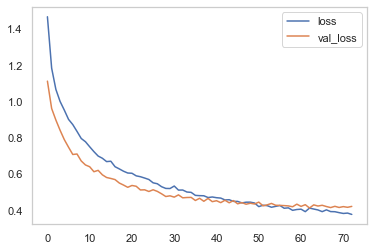

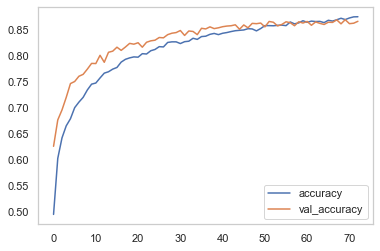

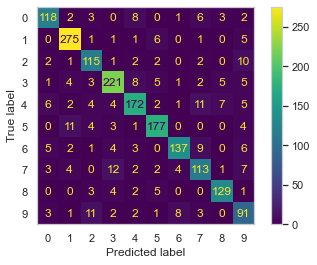

In [400]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();
nn_prediction_distributions = nn_model.predict(X_test)
nn_prediction = []
for i in range(len(nn_prediction_distributions)):
    nn_prediction.append(np.argmax(nn_prediction_distributions[i]))
    
nn_acc = accuracy_score(y_test, nn_prediction)
print("Accuracy: " + str(nn_acc))
cm = confusion_matrix(y_test, nn_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot()

## 3.8 - Baseline model evaluation

<AxesSubplot:xlabel='model', ylabel='accuracy'>

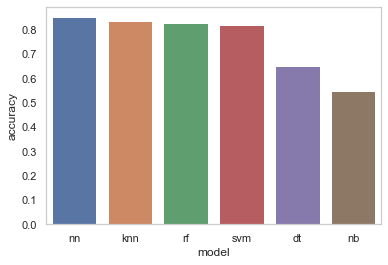

In [401]:
base_model_eval_data = { 'knn': knn_acc, 'svm': svm_acc, 'nb': nb_acc, 'dt': dt_acc,
                        'rf': rf_acc, 'nn': nn_acc }

list(base_model_eval_data.items())
base_model_eval_df = pd.DataFrame(data=list(base_model_eval_data.items()), columns=['model', 'accuracy'])
base_model_eval_df = base_model_eval_df.sort_values('accuracy', ascending=False).reset_index()
sns.barplot(x='model', y='accuracy', data=base_model_eval_df)

As shown in the graph above, the worst performant models were the Decision Tree and the Naive Bayes, which means that from now on, these will be ignored. The best model was a Neural Network with an aproximate accuracy of 92%.<br/>
On the next section, I'll be fine tuning the parameters of the best models: Neural Network, Convolutional Neural Network, KNN, Random Forest and SVM.

# 4 - Hyper-parameters fine tuning

## 4.1 - SVM tuning

In [408]:
svm_grid_search = {
    'kernel': ['linear', 'poly'],
    'gamma': [10, 100],
    'C': [1, 10],
}
svm_params = []

for k in svm_grid_search['kernel']:
    for g in svm_grid_search['gamma']:
        for c in svm_grid_search['C']:
                print("Kernel: " + k + "  Gamma: " + str(g) + "  C: " + str(c) + "....  ", end = '')
                model = SVC(kernel=k, gamma=g, C=c)
                acc = sum(cross_val_score(model, X_train, y_train, cv=3)) / 3
                svm_params.append([k, g, c, acc])
                print(" Done (" + str(acc) + ")")
            
svm_params_df = pd.DataFrame(data=svm_params, columns=['kernel', 'gamma', 'C', 'accuracy'])
svm_params_df = svm_params_df.sort_values('accuracy', ascending=False)
svm_params_df.head()

Kernel: linear  Gamma: 10  C: 1....   Done (0.6762907763565741)
Kernel: linear  Gamma: 10  C: 10....   Done (0.6794103903698628)
Kernel: linear  Gamma: 100  C: 1....   Done (0.6762907763565741)
Kernel: linear  Gamma: 100  C: 10....   Done (0.6794103903698628)
Kernel: poly  Gamma: 10  C: 1....   Done (0.8153292330382985)
Kernel: poly  Gamma: 10  C: 10....   Done (0.8153292330382985)
Kernel: poly  Gamma: 100  C: 1....   Done (0.8153292330382985)
Kernel: poly  Gamma: 100  C: 10....   Done (0.8153904063422686)


,kernel,gamma,C,accuracy
7,poly,100,10,0.815390
4,poly,10,1,0.815329
5,poly,10,10,0.815329
6,poly,100,1,0.815329
1,linear,10,10,0.679410


Accuracy: 0.8228822882288229


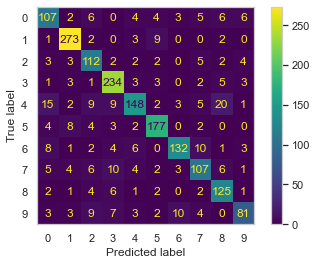

In [409]:
best_svm_params = svm_params_df.iloc[0]
best_svm_model = SVC(kernel=best_svm_params.kernel, C=best_svm_params.C, gamma=best_svm_params.gamma)
best_svm_model.fit(X_train, y_train)
best_svm_pred = best_svm_model.predict(X_test)
best_svm_acc = accuracy_score(y_test, best_svm_pred)
print("Accuracy: " + str(best_svm_acc))

cm = confusion_matrix(y_test, best_svm_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## 4.2 - Random Forest fine tuning

In [410]:
rf_grid_search = {
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2'],
    'n_estimators': [300, 400]
}
rf_params = []

for c in rf_grid_search['criterion']:
    for mf in rf_grid_search['max_features']:
        for ne in rf_grid_search['n_estimators']:
            print("Crit: " + c + "  MxFeat: " + str(mf) + "  nEst: " + str(ne)  + "....  ", end = '')
            model = RandomForestClassifier(
                criterion=c, max_features=mf, n_estimators=ne,
            )
            acc = sum(cross_val_score(model, X_train, y_train, cv=3)) / 3
            rf_params.append([c, mf, ne, acc])
            print(" Done (" + str(acc) + ")")
                     
rf_params_cols = list(rf_grid_search.keys()) + ['accuracy']
rf_params_df = pd.DataFrame(data=rf_params, columns=rf_params_cols)
rf_params_df = rf_params_df.sort_values('accuracy', ascending=False)
rf_params_df.head()

Crit: gini  MxFeat: sqrt  nEst: 300....   Done (0.8130049168744594)
Crit: gini  MxFeat: sqrt  nEst: 400....   Done (0.8138613543545009)
Crit: gini  MxFeat: log2  nEst: 300....   Done (0.8133720015961181)
Crit: gini  MxFeat: log2  nEst: 400....   Done (0.8118426128745672)
Crit: entropy  MxFeat: sqrt  nEst: 300....   Done (0.8159409211801621)
Crit: entropy  MxFeat: sqrt  nEst: 400....   Done (0.8160634810528319)
Crit: entropy  MxFeat: log2  nEst: 300....   Done (0.8137387720329122)
Crit: entropy  MxFeat: log2  nEst: 400....   Done (0.8131271063399677)


,criterion,max_features,n_estimators,accuracy
5,entropy,sqrt,400,0.816063
4,entropy,sqrt,300,0.815941
1,gini,sqrt,400,0.813861
6,entropy,log2,300,0.813739
2,gini,log2,300,0.813372


As seen in the results above, there is still room for improvement relating to the n_estimators parameter. So, I'll run some more tests to see if there are better values for this parameter.

In [411]:
rf_grid_search2 = {
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt'],
    'n_estimators': [700, 800]
}

for c in rf_grid_search2['criterion']:
    for mf in rf_grid_search2['max_features']:
        for ne in rf_grid_search2['n_estimators']:
            print("Crit: " + c + "  MxFeat: " + str(mf) + "  nEst: " + str(ne)  + "....  ", end = '')
            model = RandomForestClassifier(
                criterion=c, max_features=mf, n_estimators=ne,
            )
            acc = sum(cross_val_score(model, X_train, y_train, cv=3)) / 3
            rf_params.append([c, mf, ne, acc])
            print(" Done (" + str(acc) + ")")
                     
rf_params_cols = list(rf_grid_search.keys()) + ['accuracy']
rf_params_df = pd.DataFrame(data=rf_params, columns=rf_params_cols)
rf_params_df = rf_params_df.sort_values('accuracy', ascending=False)
rf_params_df.head()

Crit: gini  MxFeat: sqrt  nEst: 700....   Done (0.8152681607544633)
Crit: gini  MxFeat: sqrt  nEst: 800....   Done (0.8168586329843088)
Crit: entropy  MxFeat: sqrt  nEst: 700....   Done (0.81643037495868)
Crit: entropy  MxFeat: sqrt  nEst: 800....   Done (0.8172868573365593)


,criterion,max_features,n_estimators,accuracy
11,entropy,sqrt,800,0.817287
9,gini,sqrt,800,0.816859
10,entropy,sqrt,700,0.816430
5,entropy,sqrt,400,0.816063
4,entropy,sqrt,300,0.815941


Accuracy: 0.8509350935093509


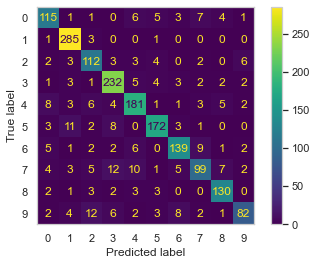

In [412]:
best_rf_params = rf_params_df.iloc[1]
best_rf_model = RandomForestClassifier(
                criterion=best_rf_params.criterion,
                max_features=best_rf_params.max_features,
                n_estimators=best_rf_params.n_estimators
            )
best_rf_model.fit(X_train, y_train)
best_rf_pred = best_rf_model.predict(X_test)
best_rf_acc = accuracy_score(y_test, best_rf_pred)
print("Accuracy: " + str(best_rf_acc))

cm = confusion_matrix(y_test, best_rf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## 4.3 - KNN fine tuning

In [426]:
knn_grid_search = {
    'n_neighbors': [2, 3, 5],
    'weights': ['distance', 'uniform'],
    'p': [1, 2],
}
knn_params = []

for nn in knn_grid_search['n_neighbors']:
    for w in knn_grid_search['weights']:
        for p in knn_grid_search['p']:
            print("NN: " + str(nn) + "  W: " + w + "  P: " + str(p) + "....  ", end = '')
            model = KNeighborsClassifier(n_neighbors=nn, weights=w, p=p)
            acc = sum(cross_val_score(model, X_train, y_train, cv=3)) / 3
            knn_params.append([nn, w, p, acc])
            print(" Done (" + str(acc) + ")")
            
knn_params_df = pd.DataFrame(data=knn_params, columns=['n_neighbors', 'weights', 'p', 'accuracy'])
knn_params_df = knn_params_df.sort_values('accuracy', ascending=False)
knn_params_df.head()

NN: 2  W: distance  P: 1....   Done (0.8693419829017809)
NN: 2  W: distance  P: 2....   Done (0.8540498130285669)
NN: 2  W: uniform  P: 1....   Done (0.847504392972815)
NN: 2  W: uniform  P: 2....   Done (0.8284806627818813)
NN: 3  W: distance  P: 1....   Done (0.8629802735737501)
NN: 3  W: distance  P: 2....   Done (0.8445070918940883)
NN: 3  W: uniform  P: 1....   Done (0.8485442830180103)
NN: 3  W: uniform  P: 2....   Done (0.8297040615145276)
NN: 5  W: distance  P: 1....   Done (0.8547837692071547)
NN: 5  W: distance  P: 2....   Done (0.8336801354567765)
NN: 5  W: uniform  P: 1....   Done (0.8361881062260393)
NN: 5  W: uniform  P: 2....   Done (0.8132495427435834)


,n_neighbors,weights,p,accuracy
0,2,distance,1,0.869342
4,3,distance,1,0.862980
8,5,distance,1,0.854784
1,2,distance,2,0.854050
6,3,uniform,1,0.848544


Accuracy: 0.8987898789878987


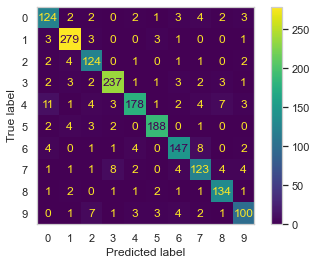

In [414]:
best_knn_params = knn_params_df.iloc[0]
best_knn_model = KNeighborsClassifier(n_neighbors=best_knn_params.n_neighbors,
                                      weights=best_knn_params.weights,
                                      p=best_knn_params.p)
best_knn_model.fit(X_train, y_train)
best_knn_pred = best_knn_model.predict(X_test)
best_knn_acc = accuracy_score(y_test, best_knn_pred)
print("Accuracy: " + str(best_knn_acc))

cm = confusion_matrix(y_test, best_knn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## 4.4 - Neural Network fine tuning

In [415]:
nn_best_params = []

In [431]:
# Define model
nn_model = keras.Sequential([
    Dense(400, activation='relu', input_shape=[len(X_train.columns)]),
    Dropout(0.5),
    Dense(300, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(10, activation='softmax')
])
nn_model.compile(metrics=['accuracy'],
                    loss='sparse_categorical_crossentropy',
                    optimizer='adam')
nn_model.summary()

early_stopping = EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True
)
history = nn_model.fit(
    _X_train, _y_train,
    validation_data=(X_val, y_val),
    epochs=1000,
    callbacks=[early_stopping])

nn_prediction_distributions = nn_model.predict(X_test)
nn_prediction = []
for i in range(len(nn_prediction_distributions)):
    nn_prediction.append(np.argmax(nn_prediction_distributions[i]))
    
nn_acc = accuracy_score(y_test, nn_prediction)
print("Accuracy: " + str(nn_acc))
#nn_best_params.append(['ftrl', nn_acc])

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 400)               17600     
_________________________________________________________________
dropout_30 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 300)               120300    
_________________________________________________________________
dropout_31 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 128)               38528     
_________________________________________________________________
dropout_32 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 10)              

Epoch 49/1000
409/409 [==============================] - 1s 2ms/step - loss: 0.4984 - accuracy: 0.8353 - val_loss: 0.4577 - val_accuracy: 0.8550
Epoch 50/1000
409/409 [==============================] - 1s 3ms/step - loss: 0.4796 - accuracy: 0.8381 - val_loss: 0.4490 - val_accuracy: 0.8550
Epoch 51/1000
409/409 [==============================] - 1s 3ms/step - loss: 0.4954 - accuracy: 0.8348 - val_loss: 0.4485 - val_accuracy: 0.8550
Epoch 52/1000
409/409 [==============================] - 1s 3ms/step - loss: 0.4842 - accuracy: 0.8384 - val_loss: 0.4455 - val_accuracy: 0.8606
Epoch 53/1000
409/409 [==============================] - 1s 3ms/step - loss: 0.4861 - accuracy: 0.8361 - val_loss: 0.4563 - val_accuracy: 0.8544
Epoch 54/1000
409/409 [==============================] - 1s 3ms/step - loss: 0.4746 - accuracy: 0.8419 - val_loss: 0.4482 - val_accuracy: 0.8535
Epoch 55/1000
409/409 [==============================] - 1s 2ms/step - loss: 0.4839 - accuracy: 0.8405 - val_loss: 0.4489 - val_ac

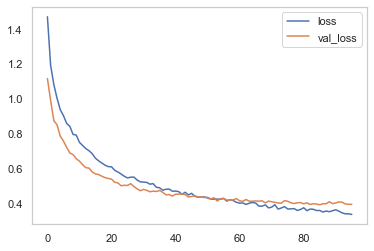

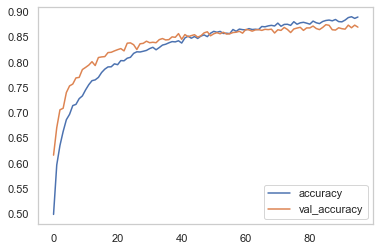

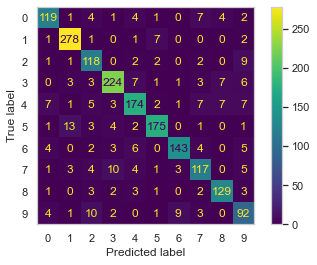

In [428]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();
nn_prediction_distributions = nn_model.predict(X_test)
nn_prediction = []
for i in range(len(nn_prediction_distributions)):
    nn_prediction.append(np.argmax(nn_prediction_distributions[i]))
    
cm = confusion_matrix(y_test, nn_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot()

In [ ]:
nn_best_params_df = pd.DataFrame(data=nn_best_params, columns=['optimizer', 'accuracy'])
nn_best_params_df

As shown in the table above, the best optimizer seems to be the 'rmsprop'.

## 4.6 - Model's fine tuning evaluation

  model  accuracy
0   knn  0.898790
1    nn  0.863036
2    rf  0.850935
3   svm  0.822882


<AxesSubplot:xlabel='model', ylabel='accuracy'>

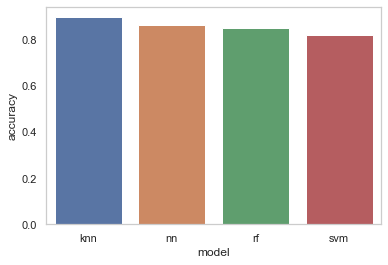

In [430]:
ft_model_eval_data = { 'knn': best_knn_acc, 'svm': best_svm_acc,
                        'rf': best_rf_acc, 'nn': nn_acc }

ft_model_eval_df = pd.DataFrame(data=list(ft_model_eval_data.items()), columns=['model', 'accuracy'])
ft_model_eval_df = ft_model_eval_df.sort_values('accuracy', ascending=False).reset_index()
print(ft_model_eval_df[['model', 'accuracy']])
sns.barplot(x='model', y='accuracy', data=ft_model_eval_df)

After tuning the different models carefully, we can conclude that the best models were the KNN and the Neural Network. Even though the CNN had 90% accuracy for the test set, it tends to overfit a lot, which is a problem. The SVM also appeared promising, but it didn't perform as well as the KNN and the NN. Finally, the Random Forest ensemble turned to be the worst model. We can hypothesise that this problem can't be efficiently solved by resorting tree based models like Decision Trees and Random Forests.